In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
print("Import libraries done.")

Import libraries done.


In [2]:
df_original = pd.read_csv(r"/Users/mexmex/Documents/3-Math_LU/HT2025/STAN48-Programming-for-Data-Science/Final Project/Data/cleaned_credit_risk_dataset.csv", index_col=0)
df_original.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
1,21,9600,5.0,1,1000,11.14,0,0.10,0,2,0,1,0,0,0,0,0,0
2,25,9600,1.0,2,5500,12.87,1,0.57,0,3,1,0,0,1,0,0,0,0
3,23,65500,4.0,2,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,0
4,24,54400,8.0,2,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,0
5,21,9900,2.0,0,2500,7.14,1,0.25,0,2,0,1,0,0,1,0,0,0


In [3]:
df = df_original.copy()
df.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
1,21,9600,5.0,1,1000,11.14,0,0.10,0,2,0,1,0,0,0,0,0,0
2,25,9600,1.0,2,5500,12.87,1,0.57,0,3,1,0,0,1,0,0,0,0
3,23,65500,4.0,2,35000,15.23,1,0.53,0,2,0,0,0,1,0,0,0,0
4,24,54400,8.0,2,35000,14.27,1,0.55,1,4,0,0,0,1,0,0,0,0
5,21,9900,2.0,0,2500,7.14,1,0.25,0,2,0,1,0,0,1,0,0,0


In [4]:
df['loan_status'].value_counts()

loan_status
0    25321
1     7088
Name: count, dtype: int64

In [36]:
class LogisticRegression:
    def __init__(self, Y_resp, X_data):
        self.X = np.c_[np.ones(len(X_data)), (X_data - np.mean(X_data, axis=0)) / (np.std(X_data, axis=0)+ 1e-12)]
        self.Y = Y_resp

    def loglik(self, betas):
        return betas @ self.X.T @ self.Y - np.sum(np.log(1 + np.exp(self.X @ betas)))

    def grad_loglik(self, betas):
       
        #print("X matrix =", self.X)
        return self.X.T @ (self.Y - 1 / (1 + np.exp(-self.X @ betas)))

    def hess_loglik(self, betas):
       
        p = 1 / (1 + np.exp(-self.X @ betas))
        W = np.diag(p * (1 - p))
        return -self.X.T @ W @ self.X  - 1e-6 * np.eye(self.X.shape[1])
    
    def newton_raphson(self, tol=1e-6, max_iter=100):
        """ Use this method to find zeros of the gradient of the log-likelihood function.
        
        Algorithm:
        betas_new = betas - f(betas) / f'(betas)
        where f is the gradient of the log-likelihood function and f' is the Hessian of the log-likelihood function.

        So:
        betas_new = betas - grad_loglik(betas) @ inv(hess_loglik(betas))
        Use np.linalg.solve instead of np.linalg.inv for better numerical stability. And it's expensive to compute the inverse of a matrix.

        Update betas until convergence or max_iter is reached.
        """
        betas = np.zeros(self.X.shape[1])  # Initialize betas to zero vector
        for i in range(max_iter):
            #print(f"Iteration {i+1}, betas = {betas}")
            # f_betas is the gradient of the log-likelihood function at betas
            f_betas = self.grad_loglik(betas)

            # f_grad_betas is the Hessian of the log-likelihood function at betas
            f_grad_betas = self.hess_loglik(betas)
            
            betas_new = betas - np.linalg.solve(f_grad_betas, f_betas)

            if np.linalg.norm(betas_new - betas) < tol:
                #print(f"Converged in {i+1} iterations.")
                return betas_new

            betas = betas_new
        print("Max iterations reached.")
        return betas
    
    def make_predictions(self,X_test, betas, threshold=0.5):
        """ Make predictions based on the fitted model.
        If the predicted probability is greater than the threshold, predict 1 (fully paid), else 0 (charged off).
        """
        X_test = np.c_[np.ones(len(X_test)), (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)]
        probs = 1 / (1 + np.exp(-X_test @ betas))
        return (probs >= threshold).astype(int)
    
    def make_predictions_prob(self,X_test, betas, threshold=0.5):
        """ Make predictions based on the fitted model.
        If the predicted probability is greater than the threshold, predict 1 (fully paid), else 0 (charged off).
        """
        X_test = np.c_[np.ones(len(X_test)), (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)]
        
        return 1 / (1 + np.exp(-X_test @ betas))
    
    def bic(self, betas):
        return np.log(self.X.shape[0]) * (self.X.shape[1]) - 2 * self.loglik(betas)
    
    def __str__(self):
        return f"LogisticRegression with {self.X.shape[1]-1} predictors and {self.X.shape[0]} observations."    

print("LogisticRegression class defined.")

LogisticRegression class defined.


In [6]:
train_proportion = round(0.8 * df.shape[0])
train_proportion

25927

In [7]:
X_train = df.loc[:train_proportion-1, df.columns != 'loan_status']
y_train = df['loan_status'].loc[:train_proportion-1]

X_test = df.loc[train_proportion:, df.columns != 'loan_status']
y_test = df['loan_status'].loc[train_proportion:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((25799, 17), (25799,), (6610, 17), (6610,))

In [8]:
type(X_train)

pandas.core.frame.DataFrame

In [37]:
model0 = LogisticRegression(Y_resp=y_train, X_data=X_train)
print(model0)

LogisticRegression with 17 predictors and 25799 observations.


In [38]:
model0_betas = model0.newton_raphson()

In [33]:
import numpy as np
from scipy.stats import binomtest

class ConfusionMatrix:
    def __init__(self, y_true, y_pred):
        self.y_true = np.array(y_true)
        self.y_pred = np.array(y_pred)

        # Basic counts
        self.tp = np.sum((self.y_true == 1) & (self.y_pred == 1))
        self.tn = np.sum((self.y_true == 0) & (self.y_pred == 0))
        self.fp = np.sum((self.y_true == 0) & (self.y_pred == 1))
        self.fn = np.sum((self.y_true == 1) & (self.y_pred == 0))
        self.n = len(self.y_true)

        # Metrics
        self.accuracy = (self.tp + self.tn) / self.n
        self.precision = self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0
        self.recall = self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0  # Sensitivity
        self.specificity = self.tn / (self.tn + self.fp) if (self.tn + self.fp) > 0 else 0
        self.f1_score = (
            2 * (self.precision * self.recall) / (self.precision + self.recall)
            if (self.precision + self.recall) > 0 else 0
        )

        # No Information Rate (majority class proportion)
        majority_class_count = max(np.sum(self.y_true == 0), np.sum(self.y_true == 1))
        self.nir = majority_class_count / self.n

        # Binomial test for accuracy > NIR
        # Null: accuracy <= NIR, Alternative: accuracy > NIR
        successes = self.tp + self.tn  # correct predictions
        self.p_value = binomtest(successes, n=self.n, p=self.nir, alternative="greater").pvalue

    def __str__(self):
        return (
            f"Confusion Matrix:\n"
            f"TP: {self.tp}, TN: {self.tn}, FP: {self.fp}, FN: {self.fn}\n"
            f"Accuracy: {self.accuracy:.4f}, "
            f"Precision: {self.precision:.4f}, "
            f"Sensitivity: {self.recall:.4f}, "
            f"Specificity: {self.specificity:.4f}, "
            f"F1 Score: {self.f1_score:.4f}\n"
            f"No Information Rate (NIR): {self.nir:.4f}, "
            f"p-value(Acc > NIR): {self.p_value:.4g}"
        )


In [68]:
model0_y_pred = model0.make_predictions(X_test=X_test, betas=model0_betas, threshold=0.5)
model0_y_pred.shape

(6610,)

In [70]:
print(ConfusionMatrix(y_true=y_test, y_pred=model0_y_pred))

Confusion Matrix:
TP: 741, TN: 4951, FP: 354, FN: 564
Accuracy: 0.8611, Precision: 0.6767, Sensitivity: 0.5678, Specificity: 0.9333, F1 Score: 0.6175
No Information Rate (NIR): 0.8026, p-value(Acc > NIR): 6.239e-36


In [14]:
class LinearRegression():
    def __init__(self, Y_resp, X_data):
        self.X = np.c_[np.ones(len(X_data)), (X_data - np.mean(X_data, axis=0)) / np.std(X_data, axis=0)]
        self.Y = Y_resp
    
    def betas_estimates(self):
        return np.linalg.solve(self.X.T @ self.X, self.X.T @ self.Y)
    
    def Y_hat(self, betas_estimates):
        return self.X @ betas_estimates
    
print("LinearRegression class defined.")

LinearRegression class defined.


In [15]:
X_data = df.loc[:, df.columns != 'loan_status']
X_data.head()

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
1,21,9600,5.0,1,1000,11.14,0.10,0,2,0,1,0,0,0,0,0,0
2,25,9600,1.0,2,5500,12.87,0.57,0,3,1,0,0,1,0,0,0,0
3,23,65500,4.0,2,35000,15.23,0.53,0,2,0,0,0,1,0,0,0,0
4,24,54400,8.0,2,35000,14.27,0.55,1,4,0,0,0,1,0,0,0,0
5,21,9900,2.0,0,2500,7.14,0.25,0,2,0,1,0,0,1,0,0,0


In [16]:
def vif(X_data):
    X_columns = X_data.columns
    X_data = X_data.values
    vif_dict = {}
    for i in range(X_data.shape[1]):
        model_X_j =  LinearRegression(Y_resp=X_data[:,i], X_data=np.delete(X_data,i, axis=1))
        betas = model_X_j.betas_estimates()
        X_j_hat =model_X_j.Y_hat(betas)
        #R_squared = (np.linalg.norm(X_j_hat) / np.linalg.norm(X_data[:,i]))**2
        residuals = X_data[:,i] - X_j_hat
        R_squared = 1 - (np.sum(residuals**2) / np.sum((X_data[:,i] - np.mean(X_data[:,i]))**2))

        vif_j = 1/(1-R_squared)
        vif_dict[X_columns[i]] = vif_j
    
    return vif_dict



In [17]:
vif0 = vif(X_data=X_data)
vif_df = pd.DataFrame(list(vif0.items()), columns=["Variable", "VIF"]).sort_values(by='VIF',ascending=False)
vif_df
# loan_grade is the most problematic variable
# exclude

,Variable,VIF
3,loan_grade,8.734323
5,loan_int_rate,8.362199
0,person_age,4.442829
8,cb_person_cred_hist_length,4.379426
4,loan_amnt,2.559309
6,loan_percent_income,2.484904
1,person_income,1.805183
12,loan_intent_MEDICAL,1.592588
13,loan_intent_VENTURE,1.566066
14,loan_intent_PERSONAL,1.552921


In [18]:
X_data_excl = df.loc[:train_proportion-1].drop(columns=['loan_status', 'loan_grade'])
#main_effects = list(X_data_excl.columns)
X_data_excl

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OWN,person_home_ownership_OTHER,loan_intent_MEDICAL,loan_intent_VENTURE,loan_intent_PERSONAL,loan_intent_HOMEIMPROVEMENT,loan_intent_DEBTCONSOLIDATION
1,21,9600,5.0,1000,11.140000,0.10,0,2,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.870000,0.57,0,3,1,0,0,1,0,0,0,0
3,23,65500,4.0,35000,15.230000,0.53,0,2,0,0,0,1,0,0,0,0
4,24,54400,8.0,35000,14.270000,0.55,1,4,0,0,0,1,0,0,0,0
5,21,9900,2.0,2500,7.140000,0.25,0,2,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25922,31,19968,1.0,2500,9.620000,0.13,0,6,0,0,0,0,0,0,0,0
25923,28,92004,2.0,7000,9.630000,0.08,0,8,1,0,0,0,1,0,0,0
25924,29,92052,6.0,6500,7.327651,0.07,0,9,1,0,0,0,0,0,1,0
25925,31,20000,7.0,2500,12.530000,0.13,1,10,0,0,0,0,0,0,0,0


In [19]:
selected_mains = []
selected_interaction = []
current_bic = np.inf
X_current = np.empty((len(y_train), 0))
null_model = LogisticRegression(Y_resp=y_train,X_data=X_current)
null_model_betas = null_model.newton_raphson()
current_bic = null_model.bic(null_model_betas)
print(f"Initial BIC (null model): {current_bic:.3f}")

Initial BIC (null model): 27466.379


In [20]:
# Forward selection with main effects and two-way interaction
def forward_selection_bic(y_resp, X_data):
    main_effects = list(X_data.columns)
    print("Main effects initially: ", main_effects)
    selected_mains = []
    selected_interaction = []
    current_bic = np.inf
    X_current = np.empty((len(y_resp), 0))
    null_model = LogisticRegression(Y_resp=y_resp,X_data=X_current)
    null_model_betas = null_model.newton_raphson()
    current_bic = null_model.bic(null_model_betas)
    print(f"Initial BIC (null model): {current_bic:.3f}")

    # Precompute all interactions once
    interaction_dict = {}
    for i, a in enumerate(main_effects):
        for b in main_effects[i+1:]:
            interaction_dict[(tuple(sorted((a, b))))] = X_data[a] * X_data[b]

    # Forward selection with interactions
    while main_effects:
        bic_candidate = []
        print("Selected main: ", selected_mains)
        print("Selected interaction: ", selected_interaction)
        # Try adding main effects
        for candidate in main_effects:
            cols = selected_mains + [candidate]
            interaction_cols = [interaction_dict[tuple(sorted(pair))] for pair in selected_interaction]

            
            #print("Main effect as candidate: ",candidate)
        
            X_candidate = pd.concat([X_data[cols]] + interaction_cols, axis=1)

            try:
                candidate_model = LogisticRegression(Y_resp=y_resp,X_data=X_candidate)
                candidate_model_betas = candidate_model.newton_raphson()
                bic_candidate.append((candidate_model.bic(betas=candidate_model_betas), candidate, 'main'))
                #print(bic_candidate[-1])
            except Exception as e:
                print(f"Skipping {candidate} due to error: {e}")
                continue
        
        for main_selected in selected_mains:
            for main_candidate in main_effects:
                if main_candidate != main_selected:
                    #print("Candidate interaction: ", (main_selected, main_candidate))
                    interaction_key = tuple(sorted((main_selected, main_candidate)))
                    X_candidate = pd.concat([X_data[selected_mains],
                                             interaction_dict[interaction_key]],
                                             axis=1)
                    try:
                        candidate_model = LogisticRegression(Y_resp=y_train,X_data=X_candidate)
                        condidate_model_betas = candidate_model.newton_raphson()
                        bic_candidate.append((candidate_model.bic(betas=candidate_model_betas), (main_selected, main_candidate), 'interaction'))
                    except:
                        continue
        
        if not bic_candidate:
            break

        bic_candidate.sort()
        best_bic, best_candidate, candidate_type = bic_candidate[0]
        #print("BIC candidate best :", best_bic)

        if best_bic < current_bic:
            current_bic = best_bic
            if candidate_type == "main":
                selected_mains.append(best_candidate)
                main_effects.remove(best_candidate)
                print(f"Add main effect {best_candidate}, BIC: {current_bic:.3f}")
            elif candidate_type == "interaction":
                selected_interaction.append(best_candidate)
                print(f"Add interaction {best_candidate}, BIC: {current_bic:.3f}")
        else:
            break
     
    
    return selected_mains, selected_interaction, best_bic


    
            
        
        


In [21]:
print(forward_selection_bic(y_resp=y_train, X_data=X_data_excl))

Main effects initially:  ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OWN', 'person_home_ownership_OTHER', 'loan_intent_MEDICAL', 'loan_intent_VENTURE', 'loan_intent_PERSONAL', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_DEBTCONSOLIDATION']
Initial BIC (null model): 27466.379
Selected main:  []
Selected interaction:  []
Add main effect loan_percent_income, BIC: 24016.980
Selected main:  ['loan_percent_income']
Selected interaction:  []
Add main effect loan_int_rate, BIC: 21438.056
Selected main:  ['loan_percent_income', 'loan_int_rate']
Selected interaction:  []
Add main effect loan_amnt, BIC: 20554.092
Selected main:  ['loan_percent_income', 'loan_int_rate', 'loan_amnt']
Selected interaction:  []
Add main effect person_home_ownership_OWN, BIC: 19883.919
Selected main:  ['loan_percent_income', 'loan_int_rate', '

In [59]:
selected_mains = [
    'loan_percent_income', 
    'loan_int_rate', 
    'loan_amnt', 
    'person_home_ownership_OWN', 
    'person_home_ownership_MORTGAGE', 
    'loan_intent_HOMEIMPROVEMENT', 
    'loan_intent_MEDICAL', 
    'loan_intent_DEBTCONSOLIDATION', 
    'loan_intent_PERSONAL', 
    'cb_person_cred_hist_length']
selected_interaction = [('loan_int_rate', 'loan_intent_DEBTCONSOLIDATION')]
df['loan_int_rate_x_loan_intent_DEBTCONSOLIDATION'] = df['loan_int_rate'] * df['loan_intent_DEBTCONSOLIDATION']
X_train1 = df.loc[:train_proportion-1, selected_mains + ['loan_int_rate_x_loan_intent_DEBTCONSOLIDATION']]
X_test1 = df.loc[train_proportion:, selected_mains + ['loan_int_rate_x_loan_intent_DEBTCONSOLIDATION']]
X_train1[X_train['loan_intent_DEBTCONSOLIDATION'] == 1], X_test1.shape

(       loan_percent_income  loan_int_rate  loan_amnt  \
 15                    0.06      10.650000      30000   
 18                    0.31      18.250000      35000   
 33                    0.08      13.850000      24250   
 37                    0.47      14.540000      30000   
 39                    0.42      15.361448      30000   
 ...                    ...            ...        ...   
 25858                 0.27       7.400000       2650   
 25863                 0.16       7.880000      14700   
 25865                 0.17      16.290000       2600   
 25874                 0.08      13.490000       2600   
 25882                 0.24       6.910000      22000   
 
        person_home_ownership_OWN  person_home_ownership_MORTGAGE  \
 15                             0                               1   
 18                             0                               0   
 33                             0                               0   
 37                             0     

In [60]:
model1 = LogisticRegression(y_train,X_train1)
print(model1)

LogisticRegression with 11 predictors and 25799 observations.


In [61]:
model1_betas = model1.newton_raphson()


In [63]:
model1_y_pred = model1.make_predictions(X_test=X_test1, betas=model1_betas, threshold=0.5)
print(ConfusionMatrix(y_test, y_pred1))
'''
Confusion Matrix:
TP: 741, TN: 4951, FP: 354, FN: 564
Accuracy: 0.8611, Precision: 0.6767, Recall (Sensitivity): 0.5678, Specificity: 0.9333, F1 Score: 0.6175
No Information Rate (NIR): 0.8026, p-value(Acc > NIR): 6.239e-36
'''

Confusion Matrix:
TP: 698, TN: 4955, FP: 350, FN: 607
Accuracy: 0.8552, Precision: 0.6660, Sensitivity: 0.5349, Specificity: 0.9340, F1 Score: 0.5933
No Information Rate (NIR): 0.8026, p-value(Acc > NIR): 3.696e-29


'\nConfusion Matrix:\nTP: 741, TN: 4951, FP: 354, FN: 564\nAccuracy: 0.8611, Precision: 0.6767, Recall (Sensitivity): 0.5678, Specificity: 0.9333, F1 Score: 0.6175\nNo Information Rate (NIR): 0.8026, p-value(Acc > NIR): 6.239e-36\n'

In [73]:
def roc_curve(y_true, p_hat):
    # sort predicted probability descending
    order_desc = np.argsort(-p_hat)
    y_true = y_true[order_desc]
    p_hat = p_hat[order_desc]

    thresholds = np.r_[np.inf, np.unique(p_hat)]
    tpr, fpr = [], []
    P = np.sum(y_true == 1)
    N = np.sum(y_true == 0)

    for thr in thresholds:
        y_pred = (p_hat >= thr).astype(int)
        TP = np.sum((y_true == 1) & (y_pred == 1))
        FP = np.sum((y_true == 0) & (y_pred == 1))
        tpr.append(TP / P if P > 0 else 0)
        fpr.append(FP / N if N > 0 else 0)
    return np.array(fpr), np.array(tpr), thresholds

# Find optimal threshold: closest to top-left (max TPR, max specificity)
def optimal_threshold(y_true, p_hat):
    fpr, tpr, thresholds = roc_curve(y_true, p_hat)
    specificity = 1 - fpr
    distances = np.sqrt((1 - tpr)**2 + (1 - specificity)**2)
    idx = np.argmin(distances)
    return thresholds[idx], fpr, tpr, thresholds, idx

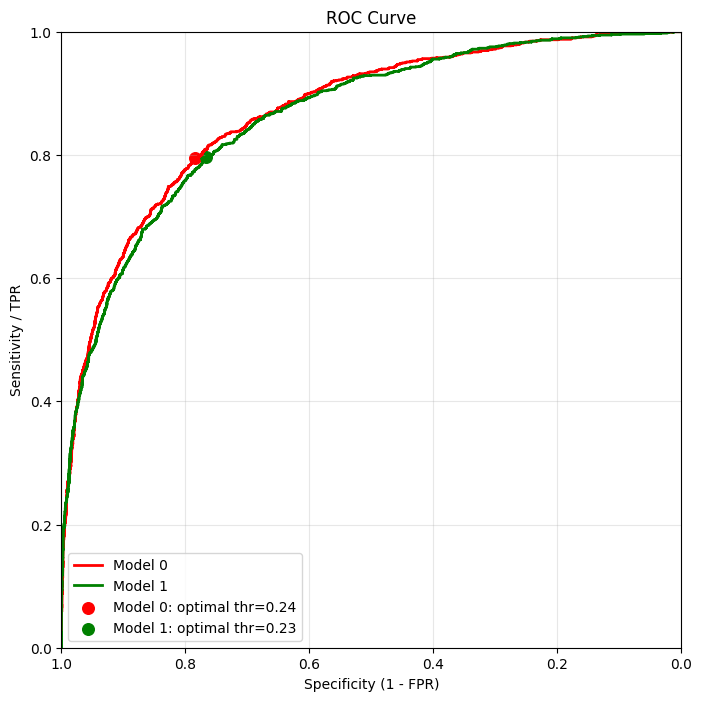

In [76]:
y_true = y_test.values
p_hat0 = model0.make_predictions_prob(X_test,model0_betas)
p_hat1 = model1.make_predictions_prob(X_test1,model1_betas)


best_threshold0, fpr0, tpr0, thresholds0, idx0 = optimal_threshold(y_true, p_hat0)
best_threshold1, fpr1, tpr1, thresholds1, idx1 = optimal_threshold(y_true, p_hat1)

specificity0 = 1 - fpr0
specificity1 = 1 - fpr1
plt.figure(figsize=(8,8))
order0 = np.argsort(-specificity0)  # ensure left->right goes 1->0
order1 = np.argsort(-specificity1)  # ensure left->right goes 1->0
# Plot both ROC curves
plt.plot(specificity0[order0], tpr0[order0], lw=2, label='Model 0', color='red')
plt.plot(specificity1[order1], tpr1[order1], lw=2, label='Model 1',color='green')

# make optimal threshold
plt.scatter(specificity0[idx0], tpr0[idx0], color='red', s=70, label=f'Model 0: optimal thr={best_threshold0:.2f}')
plt.scatter(specificity1[idx1], tpr1[idx1], color='green', s=70, label=f'Model 1: optimal thr={best_threshold1:.2f}')

plt.xlabel('Specificity (1 - FPR)')
plt.ylabel('Sensitivity / TPR')
plt.title('ROC Curve')
plt.xlim(1,0)  # top-left = high specificity
plt.ylim(0,1)
plt.legend(loc='lower left')
plt.grid(alpha=0.3)
plt.show()


In [72]:
model0_y_pred_new = model0.make_predictions(X_test,model0_betas, threshold=best_threshold0)
model1_y_pred_new = model0.make_predictions(X_test1,model1_betas, threshold=best_threshold1)
print(f"Model 0: {ConfusionMatrix(y_test,model0_y_pred_new)} \n \n Model 1: {ConfusionMatrix(y_test,model1_y_pred_new)}")

Model 0: Confusion Matrix:
TP: 1037, TN: 4164, FP: 1141, FN: 268
Accuracy: 0.7868, Precision: 0.4761, Sensitivity: 0.7946, Specificity: 0.7849, F1 Score: 0.5955
No Information Rate (NIR): 0.8026, p-value(Acc > NIR): 0.9993 
 
 Model 1: Confusion Matrix:
TP: 1040, TN: 4065, FP: 1240, FN: 265
Accuracy: 0.7723, Precision: 0.4561, Sensitivity: 0.7969, Specificity: 0.7663, F1 Score: 0.5802
No Information Rate (NIR): 0.8026, p-value(Acc > NIR): 1
